# Figure 5: Larger datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from dendrosplit import split,merge,utils
from dendrosplit_pipeline import *
sys.setrecursionlimit(5000)
%matplotlib inline

In [2]:
import os,pickle,h5py
from sklearn.metrics import adjusted_rand_score

datadir = '../data/'

# Load stuff
def save_mat_h5f(X,flname):
    h5f = h5py.File(flname, 'w')
    h5f.create_dataset('dataset_1', data=X)
    h5f.close()
    
def load_mat_h5f(flname):
    h5f = h5py.File(flname,'r')
    X = h5f['dataset_1'][:]
    h5f.close()
    return X

def load_dataset(dataset):
    start_load = time.time()
    X = load_mat_h5f('%s%s/%s_expr.h5'%(datadir,dataset,dataset))
    Y = np.loadtxt('%s%s/%s_labels.txt'%(datadir,dataset,dataset),dtype=str,delimiter='RAAAWRRRR')
    if os.path.isfile('%s%s/%s_features.txt'%(datadir,dataset,dataset)):
        genes = np.loadtxt('%s%s/%s_features.txt'%(datadir,dataset,dataset),dtype=str)
    else: genes = np.array(range(len(X[0]))).astype(str)
    print('%s cells, %s features loaded (%.2f s elapsed)'%(len(X),len(genes),time.time()-start_load))
    return X,Y,genes

# Analysis
def generate_and_save_distmat(X,save_name,recompute=False,standardize=False):
    if os.path.isfile(save_name) and recompute is False:
        print('distances precomputed. loading..')
        D = load_mat_h5f(save_name)
    else:
        D = generate_log_corr_D(X,standardize=standardize)
        save_mat_h5f(D,save_name)
    return D

def analyze_dataset(X,genes,dataset,D=None,sthresh=30,mthresh=10,verbose=True,
                    disband_percentile=50,recompute_dist=False):
    start_analysis = time.time()
    X,genes = split.filter_genes(X,genes,0) # Remove genes with 0 counts
    if D is None:
        D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation.pickle'%(datadir,dataset,dataset),
                                      recompute=recompute_dist) # Compute distance matrix
    ys,shistory,ym,mhistory = get_clusters(D,X,sthresh=sthresh,mthresh=mthresh,
                                           verbose=verbose,dp=disband_percentile) # Get clusters
    print('analysis done (%.2f s elapsed)'%(time.time()-start_analysis))
    return X,genes,D,ys,shistory,ym,mhistory

def three_plots(x1,x2,Y,ys,ym,legend_pos=(1.5,1),markersize=5,select_inds=None):
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    split.plot_labels_legend(x1,x2,Y,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('True labels')
    plt.subplot(1,3,2)
    split.plot_labels_legend(x1,x2,ys,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('Labels after split')
    plt.subplot(1,3,3)
    split.plot_labels_legend(x1,x2,ym,show_axes=False,legend_pos=legend_pos,
                             markersize=markersize,select_inds=select_inds)
    plt.title('Labels after merge')

### Zeisel

In [3]:
%%time
dataset = 'Zeisel'
X,Y,genes = load_dataset(dataset)
print(np.shape(X))

3005 cells, 19972 features loaded (0.64 s elapsed)
(3005, 19972)
CPU times: user 135 ms, sys: 509 ms, total: 644 ms
Wall time: 641 ms


In [4]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 60
mthresh = 30
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 36.755 s.
Kept 19972 features for having > 0 counts across all cells
Potential split result: 2875 and 130
 Split score 1.8E+308
Potential split result: 2584 and 291
 Split score 1.8E+308
Potential split result: 156 and 2428
 Split score 1.8E+308
Potential split result: 16 and 140
 Split score 61.74
Potential split result: 5 and 11
 Split score 7.16
Potential split result: 59 and 81
 Split score 23.80
Potential split result: 637 and 1791
 Split score 1.8E+308
Potential split result: 13 and 624
 Split score 107.44
Potential split result: 3 and 10
 Split score 6.19
Potential split result: 31 and 593
 Split score 84.42
Potential split result: 29 and 2
 Split score 18.62
Potential split result: 437 and 156
 Split score 32.41
Potential split result: 1562 and 229
 Split score 96.55
Potential split result: 164 and 1398
 Split score 100.11
Potential split result: 18 and 146
 Split score 20.44
Potential split result: 1082 and 316
 Split score 87.65
Potential split res

Adjusted rand score (ys): 0.52
Adjusted rand score (ym): 0.52


../dendrosplit/utils.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if -1 in labels or '-1' in labels: Ncolors -= 1


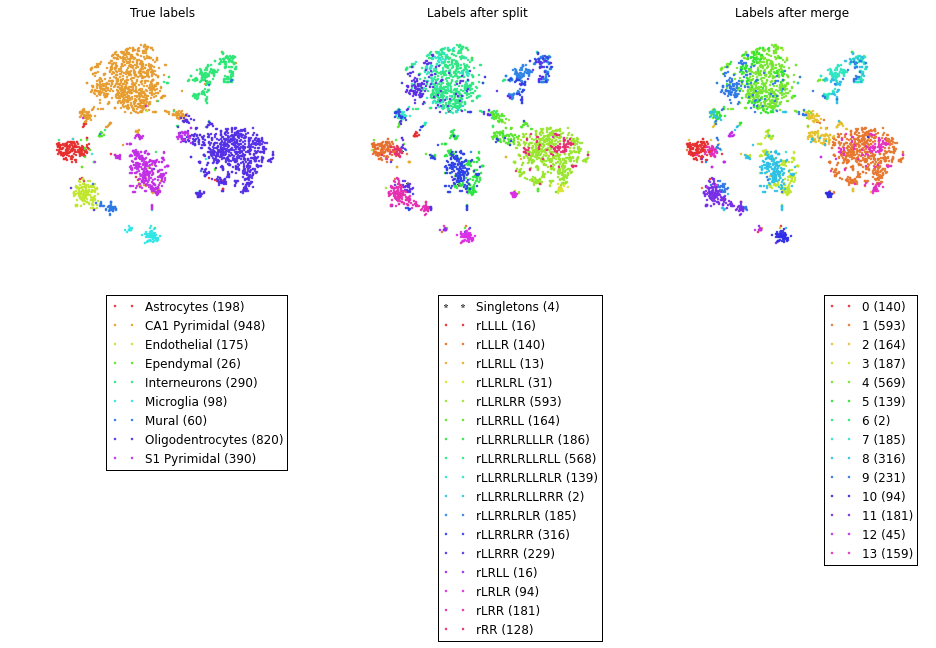

In [5]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
xtsne = np.loadtxt('%s%s/%s_reducedim_coor.txt'%(datadir,dataset,dataset))
x1,x2 = xtsne[:,0],xtsne[:,1]
three_plots(x1,x2,Y,ys,ym,markersize=4,legend_pos=(1,-0.2))

### Zeisel with gene filtering

In [6]:
%%time

# Remove all genes that have less than 0 molecules in total over all cells
X,genes = split.filter_genes(X,genes,0)

# DropSeq approach to gene selection
keep_inds = split.dropseq_gene_selection(np.log(1+X),z_cutoff=1.5,bins=5)
X,genes = X[:,keep_inds],genes[keep_inds]
print('Kept %s features after DropSeq gene selection step.'%(len(X[0])))

Kept 19972 features for having > 0 counts across all cells
Kept 1202 features after DropSeq gene selection step.
CPU times: user 3.64 s, sys: 1.04 s, total: 4.68 s
Wall time: 4.69 s


In [7]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 60
mthresh = 30
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 4.723 s.
Kept 1202 features for having > 0 counts across all cells
Potential split result: 1715 and 1290
 Split score 1.8E+308
Potential split result: 1451 and 264
 Split score 95.86
Potential split result: 1161 and 290
 Split score 177.68
Potential split result: 18 and 1143
 Split score 60.43
Potential split result: 13 and 5
 Split score 9.18
Potential split result: 801 and 342
 Split score 272.59
Potential split result: 7 and 794
 Split score 57.99
Potential split result: 84 and 258
 Split score 83.46
Potential split result: 82 and 2
 Split score 52.09
Potential split result: 156 and 102
 Split score 23.68
Potential split result: 1 and 289
Potential split result: 41 and 248
 Split score 59.33
Potential split result: 181 and 83
 Split score 104.68
Potential split result: 124 and 57
 Split score 18.56
Potential split result: 2 and 81
 Split score 48.28
Potential split result: 452 and 838
 Split score 1.8E+308
Potential split result: 202 and 250
 Split score 

Adjusted rand score (ys): 0.76
Adjusted rand score (ym): 0.76


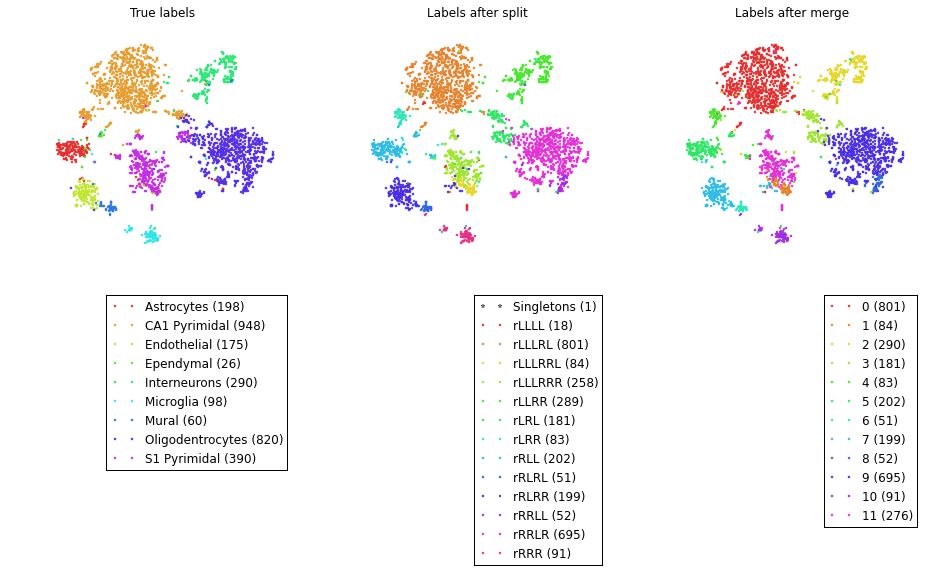

In [8]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
three_plots(x1,x2,Y,ys,ym,markersize=4,legend_pos=(1,-0.2))

/home/jessez/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


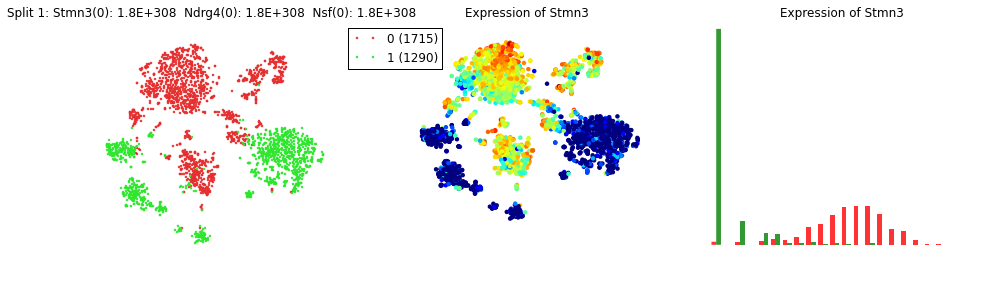

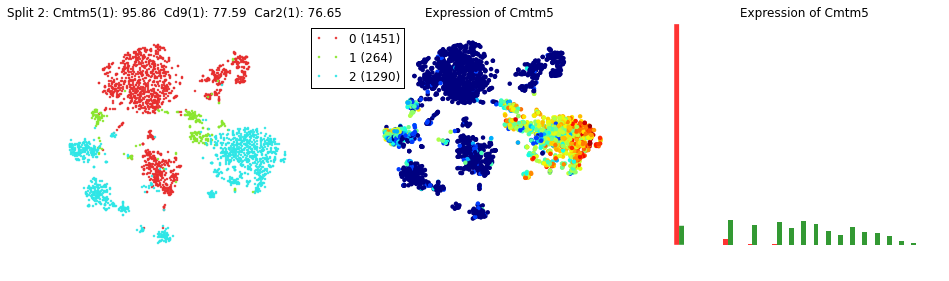

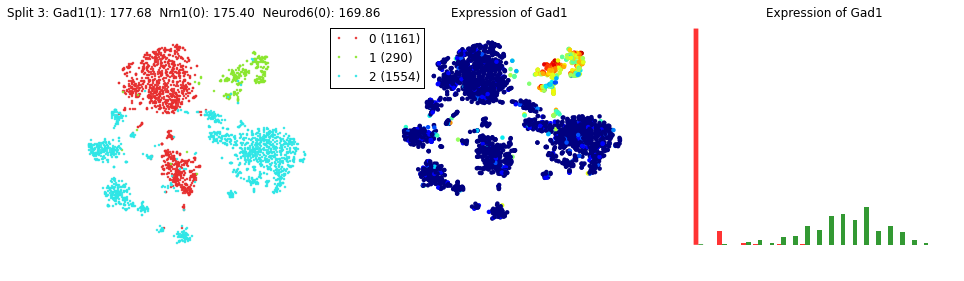

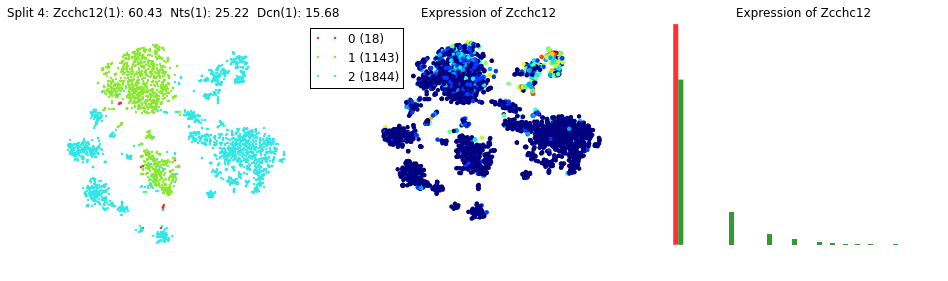

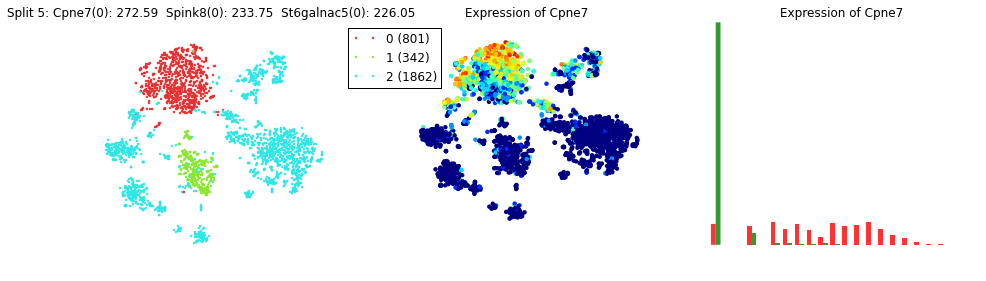

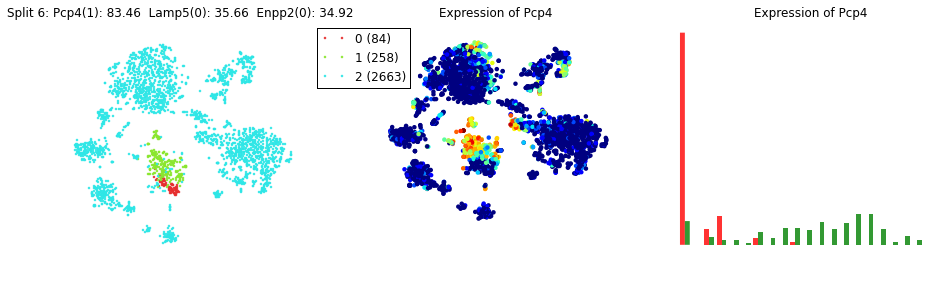

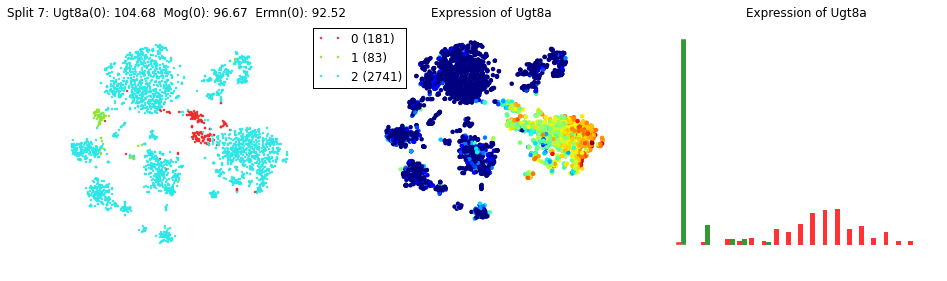

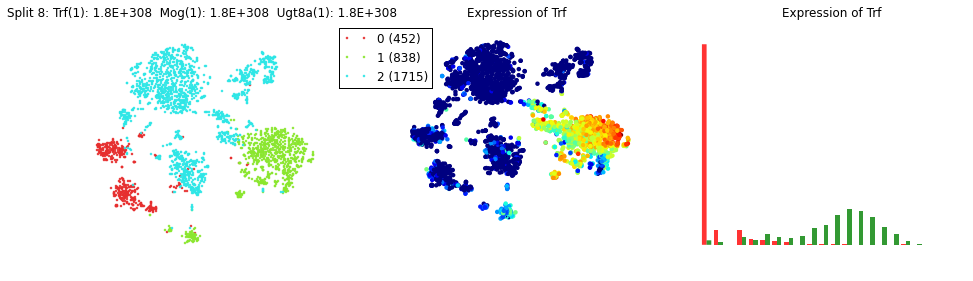

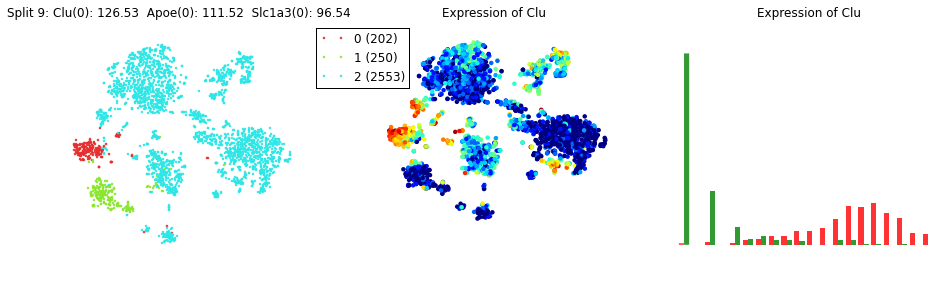

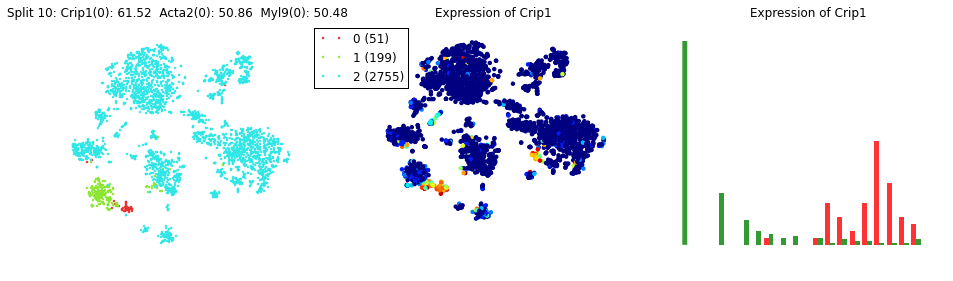

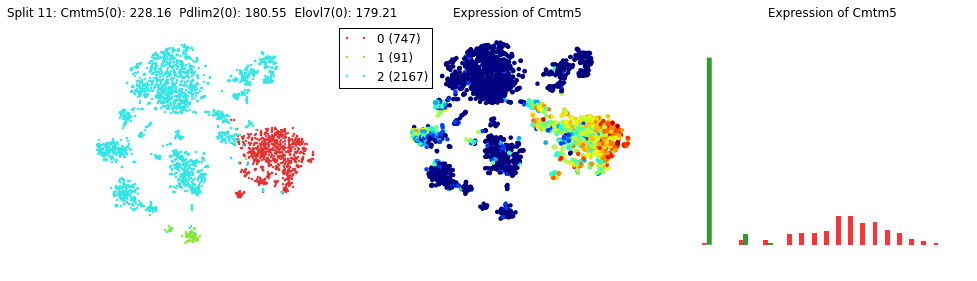

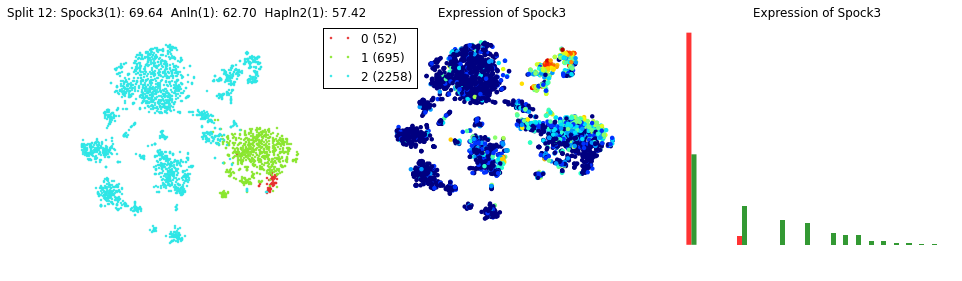

In [9]:
split.visualize_history(np.log(1+X),x1,x2,genes,shistory,axisoff=True,markersize=4)

Repeat experiment for the authors' 47 labels.

In [10]:
Y = np.loadtxt('%sZeisel/Zeisel_labels_level2class.txt'%(datadir),dtype=str,delimiter='RAERASDF')
sthresh = 15
mthresh = 7.5
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Kept 1202 features for having > 0 counts across all cells
Potential split result: 1715 and 1290
 Split score 1.8E+308
Potential split result: 1451 and 264
 Split score 95.86
Potential split result: 1161 and 290
 Split score 177.68
Potential split result: 18 and 1143
 Split score 60.43
Potential split result: 13 and 5
 Split score 9.18
Potential split result: 801 and 342
 Split score 272.59
Potential split result: 7 and 794
 Split score 57.99
Potential split result: 3 and 4
 Split score 2.95
Potential split result: 6 and 788
 Split score 62.93
Potential split result: 2 and 4
 Split score 3.24
Potential split result: 708 and 80
 Split score 11.85
Potential split result: 84 and 258
 Split score 83.46
Potential split result: 82 and 2
 Split score 52.09
Potential split result: 28 and 54
 Split score 13.25
Potential split result: 1 and 1
Potential split result: 156 and 102
 Split score 23.68
Potential split result: 52 and 104
 Split score 11.61
Potential split result: 40 and 62
 Split score 

Adjusted rand score (ys): 0.4061
Adjusted rand score (ys, ignore cells authors didnt classify): 0.4226
Adjusted rand score (ym): 0.4058
Adjusted rand score (ym, ignore cells authors didnt classify): 0.4223


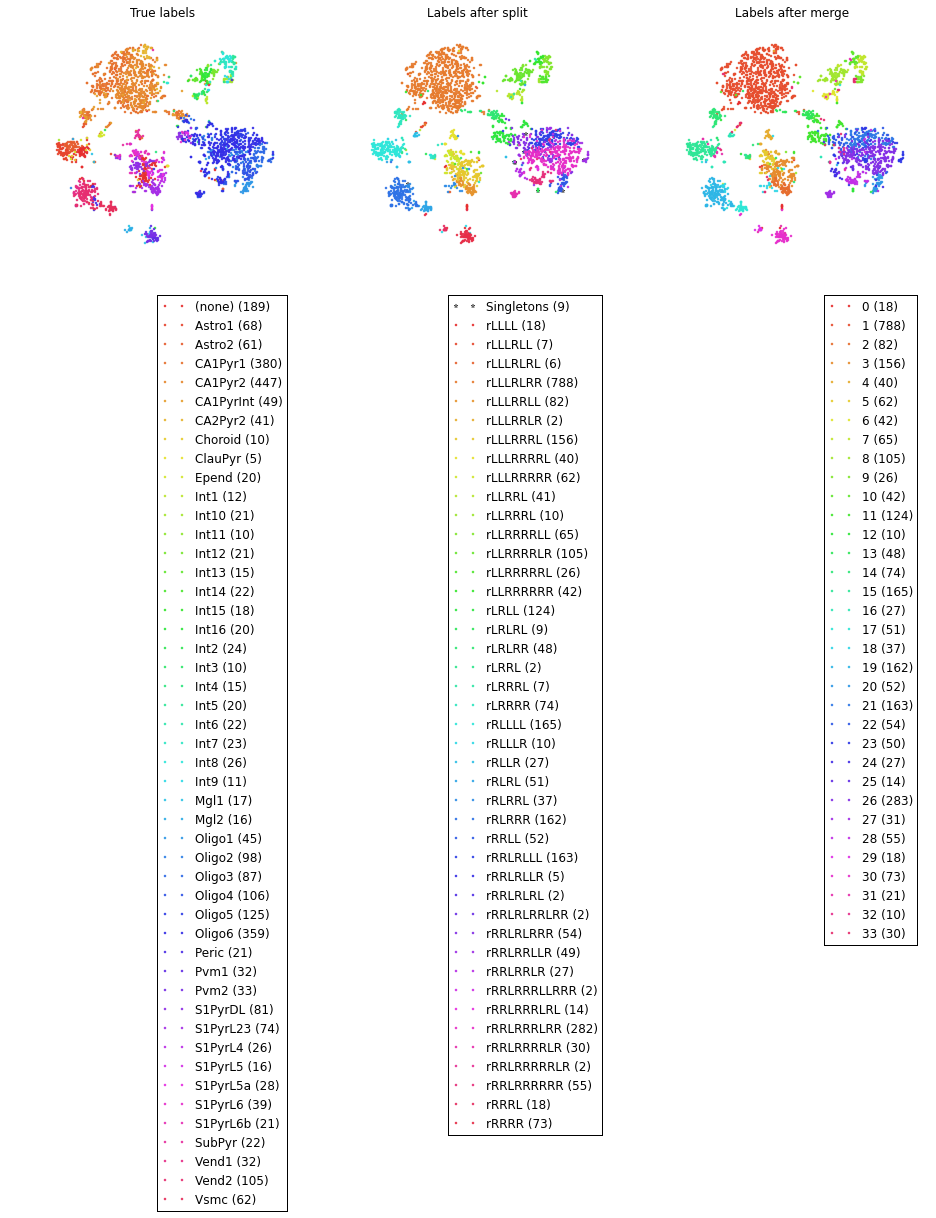

In [11]:
print('Adjusted rand score (ys): %.4f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ys, ignore cells authors didn''t classify): %.4f'
      %(adjusted_rand_score(Y[Y != '(none)'],ys[Y != '(none)'])))
print('Adjusted rand score (ym): %.4f'%(adjusted_rand_score(Y,ym)))
print('Adjusted rand score (ym, ignore cells authors didn''t classify): %.4f'
      %(adjusted_rand_score(Y[Y != '(none)'],ym[Y != '(none)'])))
three_plots(x1,x2,Y,ys,ym,markersize=4,legend_pos=(1,-0.2))

### Macosko (DropSeq)

In [12]:
%%time
dataset = 'Macosko'
X,Y,genes = load_dataset(dataset)
print(np.shape(X))

# Filter out cells that have less than 900 counts across all genes
inds = np.sum(X > 0,1) >= 900
X,Y = X[inds],Y[inds]
print('Kept %s cells for having >= 900 counts across all genes'%(len(X)))

# Remove all genes that have less than 0 molecules in total over all cells
X,genes = split.filter_genes(X,genes,0)

# DropSeq approach to gene selection
keep_inds = split.dropseq_gene_selection(np.log(1+X))
X,genes = X[:,keep_inds],genes[keep_inds]
print('Kept %s features after DropSeq gene selection step.'%(len(X[0])))

44808 cells, 24658 features loaded (7.15 s elapsed)
(44808, 24658)
Kept 11040 cells for having >= 900 counts across all genes
Kept 22685 features for having > 0 counts across all cells
Kept 1079 features after DropSeq gene selection step.
CPU times: user 22.4 s, sys: 12.7 s, total: 35.1 s
Wall time: 35.2 s


In [13]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 30
mthresh = 15
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 39.584 s.
Kept 1079 features for having > 0 counts across all cells
Potential split result: 928 and 10112
 Split score 1.8E+308
Potential split result: 762 and 166
 Split score 1.8E+308
Potential split result: 14 and 748
 Split score 1.8E+308
Potential split result: 2 and 12
 Split score 7.67
Potential split result: 37 and 711
 Split score 261.50
Potential split result: 1 and 36
Potential split result: 1 and 35
Potential split result: 1 and 34
Potential split result: 27 and 7
 Split score 5.95
Potential split result: 24 and 687
 Split score 106.66
Potential split result: 1 and 23
Potential split result: 1 and 22
Potential split result: 4 and 18
 Split score 8.14
Potential split result: 157 and 530
 Split score 89.58
Potential split result: 3 and 154
 Split score 122.47
Potential split result: 1 and 2
Potential split result: 1 and 1
Potential split result: 3 and 151
 Split score 26.82
Potential split result: 222 and 308
 Split score 83.05
Potential split resu

Adjusted rand score (ys): 0.76
Adjusted rand score (ym): 0.76


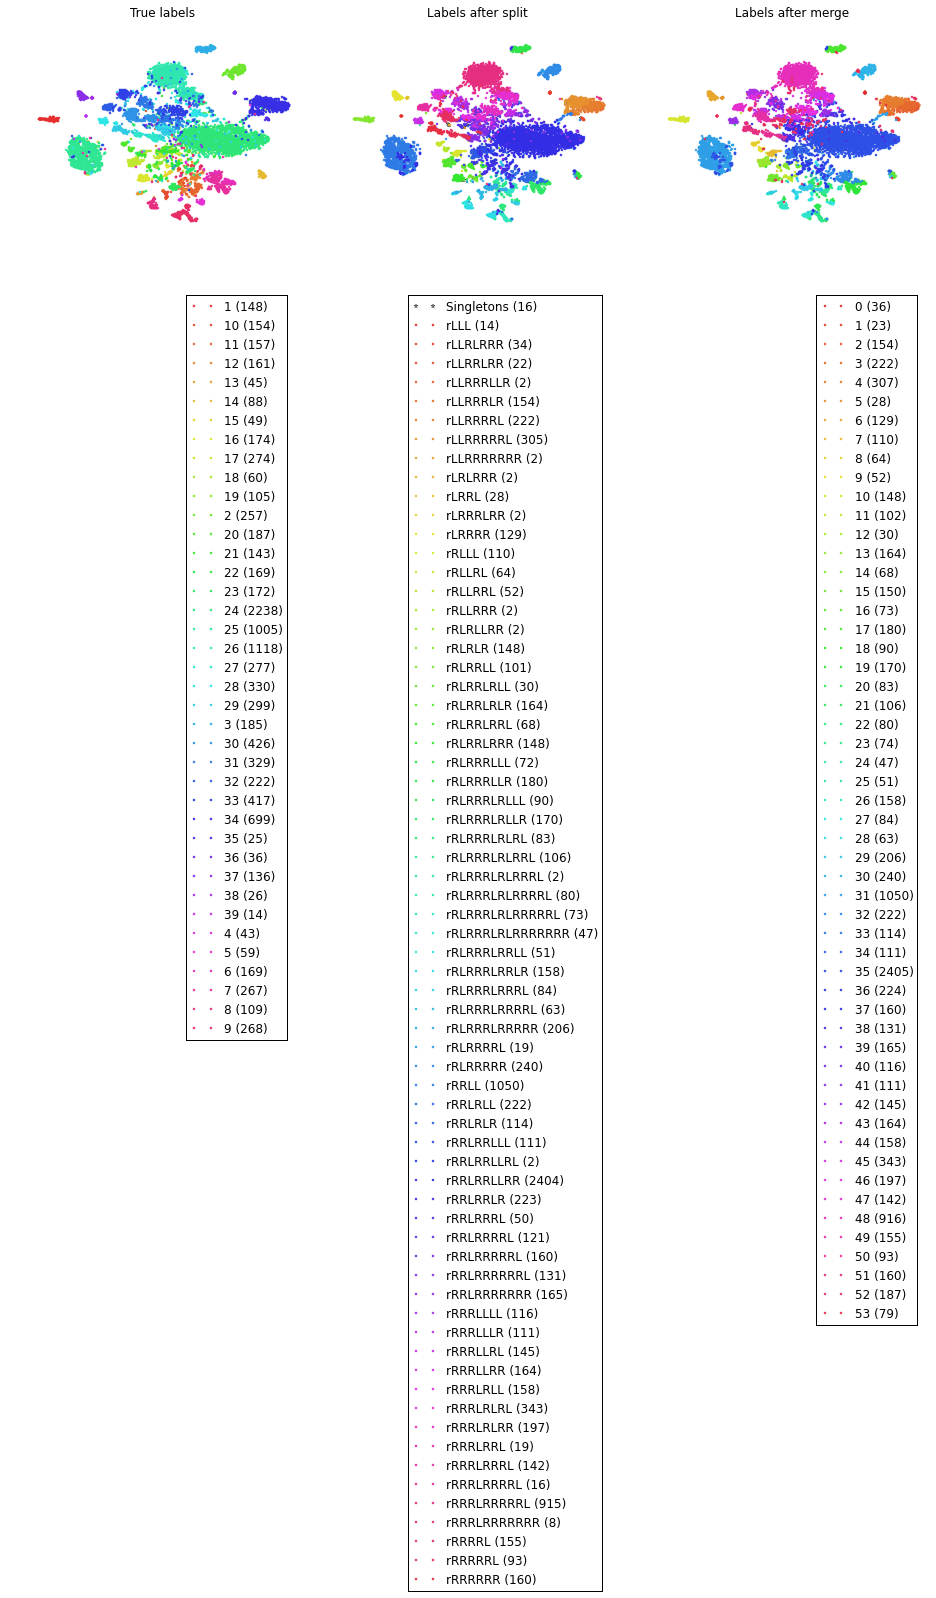

In [14]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
xtsne = np.loadtxt('%s%s/%s_reducedim_coor.txt'%(datadir,dataset,dataset))
x1,x2 = xtsne[:,0],xtsne[:,1]
three_plots(x1,x2,Y,ys,ym,markersize=4,legend_pos=(1,-0.2))

### Birey (Resolve)

In [15]:
%%time
dataset = 'Birey'
X,Y,genes = load_dataset(dataset)
print(np.shape(X))

# fix unselected cells (just label them as "singletons")
for i in range(len(Y)): 
    if 'unselected' in Y[i]: Y[i] = '-1'

# Remove all genes that have 0 molecules in total over all cells
X,genes = split.filter_genes(X,genes,0)

# DropSeq approach to gene selection
keep_inds = split.dropseq_gene_selection(np.log(1+X),z_cutoff=1.5,bins=5)
X,genes = X[:,keep_inds],genes[keep_inds]
print('Kept %s features after DropSeq gene selection step.'%(len(X[0])))

11838 cells, 27398 features loaded (3.04 s elapsed)
(11838, 27398)
Kept 25115 features for having > 0 counts across all cells
Kept 1014 features after DropSeq gene selection step.
CPU times: user 16.4 s, sys: 6.5 s, total: 22.9 s
Wall time: 22.9 s


In [16]:
%%time
D = generate_and_save_distmat(X,'%s%s/%s_D_log_correlation_%scells_%sfeatures.h5'
                              %(datadir,dataset,dataset,len(X),len(X[0])),recompute=True)
sthresh = 50
mthresh = 25
X,genes,D,ys,shistory,ym,mhistory = analyze_dataset(X,genes,dataset,sthresh=sthresh,mthresh=mthresh,D=D)

Distance matrix computed in 39.791 s.
Kept 1014 features for having > 0 counts across all cells
Potential split result: 8331 and 3507
 Split score 1.8E+308
Potential split result: 2120 and 6211
 Split score 1.8E+308
Potential split result: 237 and 1883
 Split score 71.80
Potential split result: 84 and 153
 Split score 13.91
Potential split result: 384 and 1499
 Split score 165.29
Potential split result: 20 and 364
 Split score 27.30
Potential split result: 909 and 590
 Split score 47.39
Potential split result: 1888 and 4323
 Split score 1.8E+308
Potential split result: 82 and 1806
 Split score 163.00
Potential split result: 2 and 80
 Split score 38.27
Potential split result: 181 and 1625
 Split score 167.12
Potential split result: 10 and 171
 Split score 50.65
Potential split result: 3 and 7
 Split score 2.08
Potential split result: 12 and 159
 Split score 34.44
Potential split result: 133 and 1492
 Split score 20.41
Potential split result: 3689 and 634
 Split score 234.61
Potential sp

Adjusted rand score (ys): 0.64
Adjusted rand score (ym): 0.64


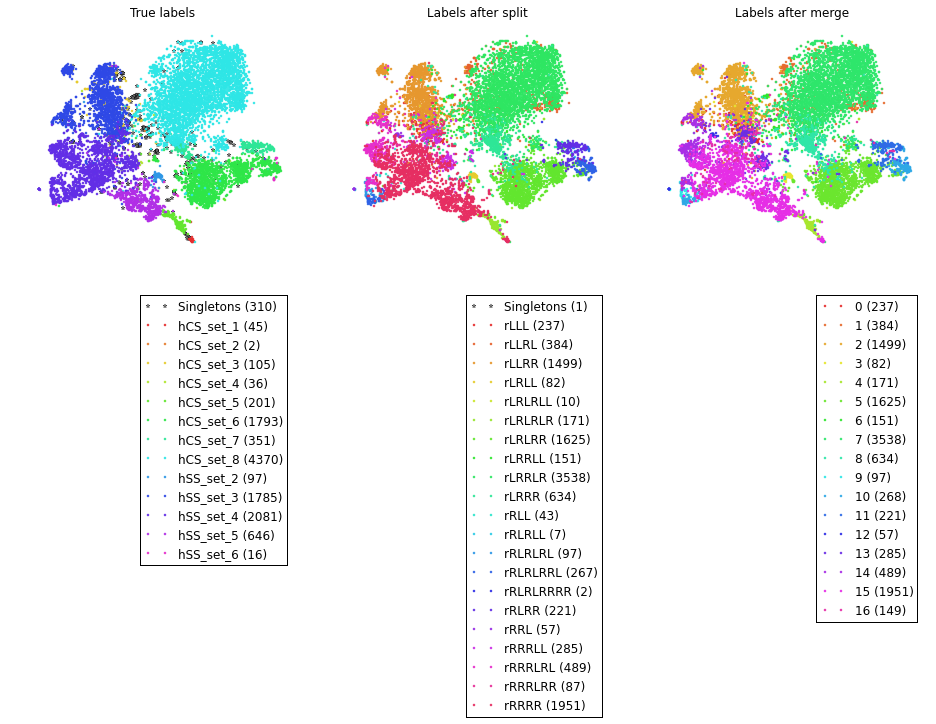

In [17]:
print('Adjusted rand score (ys): %.2f'%(adjusted_rand_score(Y,ys)))
print('Adjusted rand score (ym): %.2f'%(adjusted_rand_score(Y,ym)))
xtsne = np.loadtxt('%s%s/%s_reducedim_coor.txt'%(datadir,dataset,dataset))
x1,x2 = xtsne[:,0],xtsne[:,1]
three_plots(x1,x2,Y,ys,ym,markersize=4,legend_pos=(1,-0.2))